In [1]:
%matplotlib inline


# Benchmark over-sampling methods in a face recognition task


In this face recognition example two faces are used from the LFW
(Faces in the Wild) dataset. Several implemented over-sampling
methods are used in conjunction with a 3NN classifier in order
to examine the improvement of the classifier's output quality
by using an over-sampler.


Automatically created module for IPython interactive environment


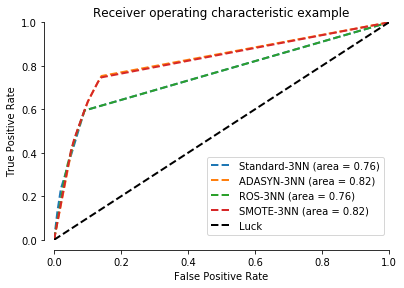

In [2]:
# Authors: Christos Aridas
#          Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

import matplotlib.pyplot as plt
import numpy as np
from scipy import interp
from sklearn import datasets, neighbors
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline
import pandas as pd
from sklearn.model_selection import train_test_split

print(__doc__)

LW = 2
RANDOM_STATE = 42


class DummySampler:

    def sample(self, X, y):
        return X, y

    def fit(self, X, y):
        return self

    def fit_resample(self, X, y):
        return self.sample(X, y)


cv = StratifiedKFold(n_splits=3)
train = pd.read_csv('data/wanzhou_island.csv')
train_labels = train['value']
train.head()

x_columns = ['Elevation', 'Slope', 'Aspect', 'TRI', 'Curvature', 'Lithology', 'River', 'NDVI', 'NDWI', 'Rainfall', 'Earthquake', 'Land_use']

X, y = train[x_columns], train_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)


classifier = ['3NN', neighbors.KNeighborsClassifier(3)]

samplers = [
    ['Standard', DummySampler()],
    ['ADASYN', ADASYN(random_state=RANDOM_STATE)],
    ['ROS', RandomOverSampler(random_state=RANDOM_STATE)],
    ['SMOTE', SMOTE(random_state=RANDOM_STATE)],
]

pipelines = [
    ['{}-{}'.format(sampler[0], classifier[0]),
     make_pipeline(sampler[1], classifier[1])]
    for sampler in samplers
]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for name, pipeline in pipelines:
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        probas_ = pipeline.fit(X_train, y_train).predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, linestyle='--',
             label='{} (area = %0.2f)'.format(name) % mean_auc, lw=LW)

plt.plot([0, 1], [0, 1], linestyle='--', lw=LW, color='k',
         label='Luck')

# make nice plotting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

plt.legend(loc="lower right")

plt.show()